#### Sitema Cotação de moedas

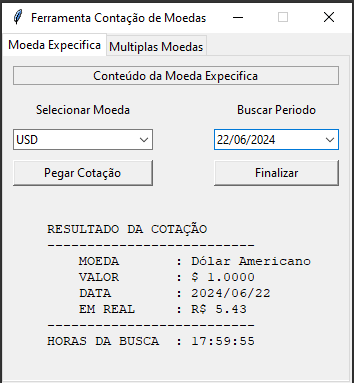 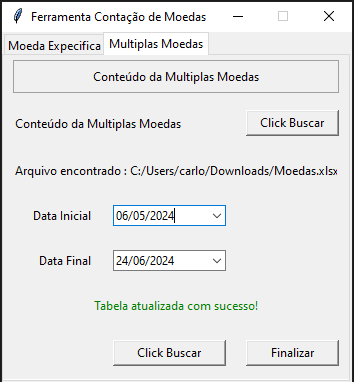

In [8]:
from tkinter import *
import tkinter as tk
from tkinter import ttk
from tkinter.filedialog import askopenfilename # buscar arquivo no seu computador
from tkcalendar import DateEntry # para usar calendario
import re
import pandas as pd
import json
import requests
from datetime import datetime
import numpy as np
from datetime import datetime



# requisicao api ----------------------------------------|
link = 'https://economia.awesomeapi.com.br/json/all' # Todas as moedas

# pegar as informações do site
contacao = requests.get(link)

# trasforma o json em um dicionario em python
dicionario_json = contacao.json()
# Data atual
data = datetime.now()

# Cria a janela principal ----------------------------------------|
janelaPrincipal = tk.Tk()
janelaPrincipal.title("Ferramenta Contação de Moedas")
janelaPrincipal.geometry('350x350')

janelaPrincipal.resizable(False, False)
# Cria o Notebook
notebook = ttk.Notebook(janelaPrincipal)
notebook.pack(fill='both',expand=True)

# Cria os frames das abas

MoedaExpecifica = ttk.Frame(notebook)
MoedaExpecifica.rowconfigure(4,weight=1)
MoedaExpecifica.columnconfigure([0,1,2],weight=1)
# adicionar aba
notebook.add(MoedaExpecifica, text='Moeda Expecifica')

MultiplasMoedas = ttk.Frame(notebook)
MultiplasMoedas.rowconfigure([0,1,2,3,4,5,6],weight=1)
MultiplasMoedas.columnconfigure([0,1,2],weight=1)
# adicionar aba
notebook.add(MultiplasMoedas, text='Multiplas Moedas')

# # conteudo auxiliar
listaMoedas = list(dicionario_json.keys())

def ordenaData(data):
    separacao = data.split('/')
    ordem = f'{separacao[2]}/{separacao[1]}/{separacao[0]}'
    return ordem

def requisicaoMoeda(moeda,data):
    '''RETORNO 
        | ---- VALOR - ULTIMA ATUALIZACAO - NOME
    '''
    link = f'https://economia.awesomeapi.com.br/json/daily/{moeda}-BRL/?start_date={data}&end_date={data}'
    contacao = requests.get(link)
    retorno = contacao.json()
    # print('>>>',retorno)
    dicionario = retorno[0]
    
    resultado = (dicionario['bid'],
                 dicionario['create_date'][-8:],
                 re.search(re.compile(r'^(\w+\s\w+)|^(\w+)'),dicionario['name']).group(0)) # <<< mais versatil porem complexo
               # dicionario['name'][:str(dicionario['name']).index('/')] # <<< mais limples porem depende de um padrao para funcionar
    return resultado


# !!! Esse sistema se divide em duas abas, para editar ambas basta observar a correta.

# Adiciona conteúdo ABA 1 ------------------------------------------|

# pady ou padx = espaçamento do conteudo ate a borda
# para ancorar um texto > anchor = 'center' ou alguma dessas direcoes anchor = 'nsew'

tituloExpecifico = ttk.Label(MoedaExpecifica, text="Conteúdo da Moeda Expecifica",borderwidth=3,relief='solid',anchor='center').grid(row=0,column=0,padx=10,pady=10,sticky='we',columnspan=3)

# ------------- selecionar moeda

label_selecionarMoeda = ttk.Label(MoedaExpecifica, text="Selecionar Moeda",anchor='center').grid(row=1,column=0,padx=10,pady=5,sticky='we',columnspan=1)
listaSuspensa = ttk.Combobox(MoedaExpecifica,values=listaMoedas,width=5)
listaSuspensa.set(listaMoedas[5])
listaSuspensa.grid(row=2,column=0,padx=10,pady=5,sticky='we',columnspan=1)

# ------------- dia para pegar a cotacao

label_selecionarDiaCotacao = ttk.Label(MoedaExpecifica, text="Buscar Periodo",anchor='center').grid(row=1,column=2,padx=10,pady=5,sticky='we',columnspan=1)

# Valor >> "year = 'atual', locale = 'pt_br'"
calendarioDiaCotacao = DateEntry(MoedaExpecifica, year = data.year, locale = 'pt_br',width=5)
calendarioDiaCotacao.grid(row=2,column=2,padx=10,pady=5,sticky='we',columnspan=1)

# ------------- exibicao
label_Resposta = ttk.Label(MoedaExpecifica, text="", justify='left', anchor='center', font=("Courier", 10))
label_Resposta.grid(row=4,column=0,padx=5,pady=10,columnspan=3,sticky='we')

botao_fecharEx = tk.Button(MoedaExpecifica,text='Finalizar',command = janelaPrincipal.destroy)
botao_fecharEx.grid(row=3,column=2,padx=10,pady=5,sticky='we')

# ------------- botao busca
def pegarCotacao():
    try:
        moeda = listaSuspensa.get()
        calendario = ordenaData(calendarioDiaCotacao.get())
        resultadoCotacao = requisicaoMoeda(moeda,calendario.replace('/',''))
        dolar = requisicaoMoeda('USD',calendario.replace('/',''))
        label_Resposta['text'] = '''
        RESULTADO DA COTAÇÃO
        --------------------------
            MOEDA       : {:<20}
            VALOR       : {:<20}
            DATA        : {:<20}
            EM REAL     : {:<20}
        --------------------------
        HORAS DA BUSCA  : {:<20}
        '''.format(resultadoCotacao[2],'$ '+f'{(float(resultadoCotacao[0]) / float(dolar[0])):,.4f}',calendario,'R$ '+ f'{float(resultadoCotacao[0]):,.2f}',resultadoCotacao[1])
        label_Resposta.configure(foreground='black')
    except Exception as e:
        label_Resposta['text'] = f'''ERRO!\n\nA cotacao do dia {calendario} desta moeda\nainda não está disponivel!\n\nTente outro dia ou Mais tarde.'''
        label_Resposta.configure(foreground='red')
        print(f"Erro: {e}")
        

botao_Cotacao = tk.Button(MoedaExpecifica,text='Pegar Cotação',command = pegarCotacao)
botao_Cotacao.grid(row=3,column=0,padx=10,pady=5,sticky='we')



# Adiciona conteúdo ABA 2 ------------------------------------------|
label_tituloMultiplos = ttk.Label(MultiplasMoedas, text="Conteúdo da Multiplas Moedas",borderwidth=3,relief='solid',anchor='center')
label_tituloMultiplos.grid(row=0,column=0,padx=10,pady=5,sticky='we',columnspan=3)

label_selecionarAquivo = ttk.Label(MultiplasMoedas, text="Conteúdo da Multiplas Moedas")
label_selecionarAquivo.grid(row=1,column=0,padx=10,pady=5,sticky='we',columnspan=2)


# botao selecionar

def selecionarArquivo():
    caminho_arquivo = askopenfilename(title='Seleciona o Arquivo de Moedas',
                                      filetypes=[("Excel files", "*.xlsx *.xls")])
    # para passar um valor a variavel do tkinter preciso usar o SET 
    axiArquivo.set(caminho_arquivo)
    
    if caminho_arquivo:
        label_AquivoSelecionado['text'] = f'Arquivo encontrado : {caminho_arquivo}'
    
axiArquivo = tk.StringVar()
botao_Selecionar = tk.Button(MultiplasMoedas,text='Click Buscar',command = selecionarArquivo)
botao_Selecionar.grid(row=1,column=2,padx=10,pady=5,sticky='we')


label_AquivoSelecionado= ttk.Label(MultiplasMoedas, text="Nenhum Aquivo Encontrado!",anchor='e')
label_AquivoSelecionado.grid(row=2,column=0,padx=10,pady=5,sticky='we',columnspan=3)

label_DataInicio= ttk.Label(MultiplasMoedas, text="Data Inicial",anchor='e').grid(row=3,column=0,padx=10,pady=5,sticky='we')
calendarioInicio = DateEntry(MultiplasMoedas, year = data.year, locale = 'pt_br')
calendarioInicio.grid(row=3,column=1,padx=10,pady=5,sticky='we')

label_DataFinal= ttk.Label(MultiplasMoedas, text="Data Final",anchor='e').grid(row=4,column=0,padx=10,pady=5,sticky='we')
calendarioFinal = DateEntry(MultiplasMoedas, year = data.year, locale = 'pt_br')
calendarioFinal.grid(row=4,column=1,padx=10,pady=5,sticky='we')


def calcularDatas():
    '''RETORNO 
        | ---- Funcao calcula e retorna uma sequecia de valores de cotacoes.
            '''
    df = pd.read_excel(axiArquivo.get()) 
    dataframe = pd.DataFrame(columns=['Data'])
    dt_inicio = ordenaData(calendarioInicio.get()).replace('/','')
    dt_final = ordenaData(calendarioFinal.get()).replace('/','')
    primeiraColuna = df.iloc[:,0] # << moedas
    quantidade = int(dt_final)-int(dt_inicio) + 1

    for moeda in primeiraColuna:
        
        # buscar cotacao - MOEDA
        link = f'https://economia.awesomeapi.com.br/json/daily/{moeda}-BRL/{quantidade}?start_date={dt_inicio}&end_date={dt_final}'
        contacao = requests.get(link)
        retorno = contacao.json()
        # vou pecorrer o - RETORNO DA MOEDA
        for linha,cotacao in enumerate(retorno):
            
            bid = float(cotacao['bid'])

            # converte numeros em datas com 'timestamp'
            timestamp = int(cotacao['timestamp'])
            data = datetime.fromtimestamp(timestamp)
            data = data.strftime('%d/%m/%Y')

            if moeda in dataframe:
                # localizo minha linha referente a moeda e passo o valor da - COTACAO e DATA
                dataframe.loc[linha, moeda] = bid
                dataframe.loc[linha, 'Data'] = data
                
            else:
                # criar uma coluna vazia
                dataframe[moeda] = np.nan
                # atualizo ela com todos os valores encontrados
                dataframe.loc[linha, moeda] = bid
                dataframe.loc[linha, 'Data'] = data
            
            
            
    dataframe.to_excel('Cotacao Atualizada.xlsx',index=False)

    # texto final
    label_resultadoMultiplos['text'] = 'Tabela atualizada com sucesso!'
    label_resultadoMultiplos.configure(foreground='green')
        

    # display(df)
    
label_resultadoMultiplos = ttk.Label(MultiplasMoedas, text="",anchor='center')
label_resultadoMultiplos.grid(row=5,column=0,padx=10,pady=5,sticky='we',columnspan=3)
botao_resultados = tk.Button(MultiplasMoedas,text='Click Buscar',command = calcularDatas).grid(row=6,column=1,padx=10,pady=5,sticky='we')

# ------------- fechar
botao_fecharMultiplas = tk.Button(MultiplasMoedas,text='Finalizar',command = janelaPrincipal.destroy).grid(row=6,column=2,padx=10,pady=5,sticky='we')


# Inicia o loop principal da aplicação
janelaPrincipal.mainloop()
